## Setup Environment

In [1]:
#!pip install transformers
#!pip install numpy --upgrade
#!pip install scikit-learn

In [2]:
import pandas as pd
import numpy as np
import seaborn as sns

from transformers import BertTokenizer
from transformers import BertModel

import torch
from torch import nn

from sklearn.model_selection import train_test_split

In [3]:
## Options:
# BERT: 'bert-base-cased'
# BERT: bert-large-cased'
# mBERT: 'bert-base-multilingual-cased'
# BETO: 'dccuchile/bert-base-spanish-wwm-cased' 

"""
In a cased model, the original casing of the input text is preserved. 
This means that the model distinguishes between uppercase and lowercase letters when processing the input text. 
For example, "Hello" and "hello" would be treated as two different words by a cased BERT model.
"""

# BERT: 'bert-base-uncased'
# BERT: 'bert-large-uncased'
# BETO: 'dccuchile/bert-base-spanish-wwm-uncased'


BERT = 'bert-base-cased'
MAX_TOKENS = 250

### Read Data

In [4]:
df = pd.read_csv('Train.csv')
df

,Tweet_ID,tweet,type
0,ID_0022DWKP,Had a dream i got raped last night. By a guy i...,sexual_violence
1,ID_00395QYM,he thought the word raped means sex and told m...,sexual_violence
2,ID_003EOSSF,She NOT TALKING TO ME I WAS RAPED BY 2 MEN 1 M...,sexual_violence
3,ID_004BBHOD,I was sexually abused for 3 years at age 4 to ...,sexual_violence
4,ID_004F7516,Chessy Prout can do better by telling the trut...,sexual_violence
...,...,...,...
39645,ID_ZZTLP2L5,"ENTRY 1299: 21F. 23M, BF’s cousin. Got drunk o...",sexual_violence
39646,ID_ZZXB10M6,So you’re telling me Emmanuel Macron was groom...,sexual_violence
39647,ID_ZZY8B7FJ,"My wife regularly beats me, I get dirty slaps ...",Physical_violence
39648,ID_ZZYAFD8L,Me: Hey babe! Police officer boyfriend: is tha...,sexual_violence


In [5]:
class_dic = {}

for i, violence_class in enumerate(np.unique(df.type)):
    class_dic[violence_class] =  i

class_dic

{'Harmful_Traditional_practice': 0,
 'Physical_violence': 1,
 'economic_violence': 2,
 'emotional_violence': 3,
 'sexual_violence': 4}

<AxesSubplot: xlabel='type', ylabel='count'>

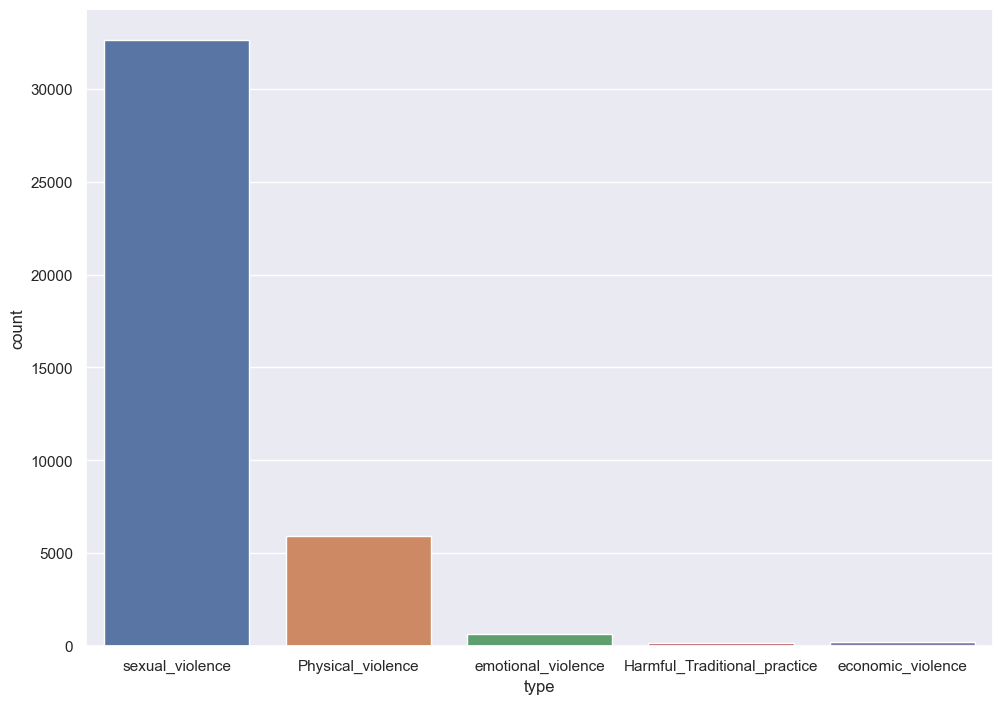

In [6]:
sns.set(rc={'figure.figsize':(11.7,8.27)})

sns.countplot(x=df['type'])

### Preprocessing

In [7]:
tokenizer = BertTokenizer.from_pretrained(BERT)

In [8]:
example_text = 'This is an example of a text'

# Encode Text:
bert_input = tokenizer(example_text, padding='max_length', max_length = 15, 
                       truncation=True, return_tensors="pt")

print(f'Original: {example_text}')
print(bert_input['input_ids']) # Words IDs
print(bert_input['token_type_ids']) # Same sentence
print(bert_input['attention_mask']) # Padding

# Decode:
example_text = tokenizer.decode(bert_input.input_ids[0])
print('')
print(f'Decoded: {example_text}')

Original: This is an example of a text
tensor([[ 101, 1188, 1110, 1126, 1859, 1104,  170, 3087,  102,    0,    0,    0,
            0,    0,    0]])
tensor([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]])
tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0]])

Decoded: [CLS] This is an example of a text [SEP] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD]


### Dataloader

In [9]:
tokenizer = BertTokenizer.from_pretrained(BERT)

class TextDataset(torch.utils.data.Dataset):
    
    def __init__(self, tokenizer, df, labels_column='type', text_column='tweet', max_length=512):
        
        self.tokenizer = BertTokenizer.from_pretrained(tokenizer)
        self.df = df
        self.labels_column = labels_column
        self.text_column = text_column

        self.labels = self._get_labels()
        
        self.texts = self._get_texts(max_length)
    
    def _get_labels(self):
        # Generate dict "label name" -> "label number"
        labels_dic = {}
        for i, label in enumerate(np.unique(self.df[self.labels_column])):
            labels_dic[label] =  i
        # Map labels
        labels = [labels_dic[label] for label in self.df[self.labels_column]]    
        return labels
    
    def _get_texts(self, max_length):
        # Generate the tokens of each text in the dataframe
        texts = [self.tokenizer(text, padding='max_length', max_length=max_length, truncation=True, return_tensors="pt") for text in self.df[self.text_column]]
        return texts

    def classes(self):
        return self.labels

    def __len__(self):
        return len(self.labels)
    
    def get_batch_labels(self, idx):
        # Fetch a batch of labels
        return np.array(self.labels[idx])

    def get_batch_texts(self, idx):
        # Fetch a batch of inputs
        return self.texts[idx]

    def __getitem__(self, idx):

        batch_texts = self.get_batch_texts(idx)
        batch_y = self.get_batch_labels(idx)

        return batch_texts, batch_y


In [10]:
def split_df(df, test_size=0.2, val_size=0.2):
    
    ######## TODO: BALANCE DATASET!!! ########
    
    print(f'Original dataset of shape: {df.shape}')
    print('Splitting...')
    
    df_train, df_test = train_test_split(df, test_size=0.2, random_state=42)
    if val_size:
        df_train, df_val = train_test_split(df_train, test_size=val_size, random_state=42)
        
        print(f'Train dataset of shape: {df_train.shape}')
        print(f'Test dataset of shape: {df_test.shape}')
        print(f'Validation dataset of shape: {df_val.shape}')
        
        return df_train, df_test, df_val
    else:
        print(f'Train dataset of shape: {df_train.shape}')
        print(f'Test dataset of shape: {df_test.shape}')
        return df_train, df_test

In [11]:
df_train, df_test, df_val = split_df(df)

Original dataset of shape: (39650, 3)
Splitting...
Train dataset of shape: (25376, 3)
Test dataset of shape: (7930, 3)
Validation dataset of shape: (6344, 3)


In [12]:
train = TextDataset(BERT, df_train, max_length=MAX_TOKENS)
test = TextDataset(BERT, df_test, max_length=MAX_TOKENS)
val = TextDataset(BERT, df_val, max_length=MAX_TOKENS)

### Modeling

In [13]:
class BertClassifier(nn.Module):

    def __init__(self, classes, BERT, dropout=0.3):

        super(BertClassifier, self).__init__()

        self.bert = BertModel.from_pretrained(BERT)
        # Bert has two outputs: 
        # 1. Sequence [Batch, Sequence, 768]
        # 2. Pooled = [Batch, 768]
        self.dropout = nn.Dropout(dropout)
        # 768 if ussing the pooled output
        self.linear = nn.Linear(768, classes)
        self.relu = nn.ReLU()

    def forward(self, input_id, mask):

        _, pooled_output = self.bert(input_ids= input_id, attention_mask=mask,return_dict=False)
        dropout_output = self.dropout(pooled_output)
        linear_output = self.linear(dropout_output)
        final_layer = self.relu(linear_output)

        return final_layer

In [14]:
n_clsses = len(np.unique(df.type))

model = BertClassifier(classes=n_clsses, BERT=BERT)
model

Some weights of the model checkpoint at bert-base-cased were not used when initializing BertModel: ['cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


BertClassifier(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(28996, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_af

### Model Training

True

In [23]:
from torch.optim import Adam
from tqdm import tqdm

def train_model(model, train, val, learning_rate, epochs):

    train_dataloader = torch.utils.data.DataLoader(train, batch_size=8, shuffle=True)
    val_dataloader = torch.utils.data.DataLoader(val, batch_size=8)

    use_gpu = torch.backends.mps.is_available()
    device = torch.device("mps" if use_gpu else "cpu")

    criterion = nn.CrossEntropyLoss()
    optimizer = Adam(model.parameters(), lr= learning_rate)

    if use_gpu:

            model = model.to(device)
            criterion = criterion.to(device)

    for epoch_num in range(epochs):

            total_acc_train = 0
            total_loss_train = 0

            for train_input, train_label in tqdm(train_dataloader):

                train_label = train_label.to(device)
                mask = train_input['attention_mask'].to(device)
                input_id = train_input['input_ids'].squeeze(1).to(device)

                output = model(input_id, mask)
                
                batch_loss = criterion(output, train_label.long())
                total_loss_train += batch_loss.item()
                
                acc = (output.argmax(dim=1) == train_label).sum().item()
                total_acc_train += acc

                model.zero_grad()
                batch_loss.backward()
                optimizer.step()
            
            total_acc_val = 0
            total_loss_val = 0

            with torch.no_grad():

                for val_input, val_label in val_dataloader:

                    val_label = val_label.to(device)
                    mask = val_input['attention_mask'].to(device)
                    input_id = val_input['input_ids'].squeeze(1).to(device)

                    output = model(input_id, mask)

                    batch_loss = criterion(output, val_label.long())
                    total_loss_val += batch_loss.item()
                    
                    acc = (output.argmax(dim=1) == val_label).sum().item()
                    total_acc_val += acc
            
            print(
                f'Epochs: {epoch_num + 1} | Train Loss: {total_loss_train / len(train): .3f} \
                | Train Accuracy: {total_acc_train / len(train): .3f} \
                | Val Loss: {total_loss_val / len(val): .3f} \
                | Val Accuracy: {total_acc_val / len(val): .3f}')

In [16]:
LR = 1e-6
EPOCHS = 2              
train_model(model, train, val, LR, EPOCHS)

100%|████████████████████████████████████| 3172/3172 [10:53:49<00:00, 12.37s/it]


Epochs: 1 | Train Loss:  0.026                 | Train Accuracy:  0.944                 | Val Loss:  0.007                 | Val Accuracy:  0.984


100%|█████████████████████████████████████| 3172/3172 [7:02:29<00:00,  7.99s/it]


Epochs: 2 | Train Loss:  0.005                 | Train Accuracy:  0.988                 | Val Loss:  0.005                 | Val Accuracy:  0.985


### Model Evaluation

In [24]:
def evaluate(model, test):

    test_dataloader = torch.utils.data.DataLoader(test, batch_size=2)

    use_gpu = torch.backends.mps.is_available()
    device = torch.device("mps" if use_gpu else "cpu")

    if use_gpu:

        model = model.to(device)

    total_acc_test = 0
    with torch.no_grad():

        for test_input, test_label in test_dataloader:
            
            test_label = test_label.to(device)
            mask = test_input['attention_mask'].to(device)
            input_id = test_input['input_ids'].squeeze(1).to(device)

            output = model(input_id, mask)

            acc = (output.argmax(dim=1) == test_label).sum().item()
            total_acc_test += acc
    
    print(f'Test Accuracy: {total_acc_test / len(test): .3f}')
    
    
    
    ######## TODO: New Metrics!!! ########
    ######## TODO: Plot Confusion Matrix!!! ########

In [25]:
evaluate(model, test)

Test Accuracy:  0.985
